# Небольшое введение

Данный ноутбук является выжимкой моей [магистерской диссертации](https://drive.google.com/file/d/1ffgEnXcTsl8M8yzAH_5lPYuSi2NeE8qo/view?usp=sharing).

Радиомика – наука о количественном анализе медицинских томографических сканов с использованием методов статистики и машинного обучения. В большинстве исследований изучают онкологические заболевания.

## Пайплайн исследований
1. Создается выборка томографических сканов и выполняется их предобработка
2. На каждом изображении оконтуривается опухоль, это так называемая область интереса или ROI (region of interests)
3. Для этой области рассчитываются различные признаки (например, текстурные на основе матрицы GLCM) или БМИ (биомаркеры изображений)
4. Полученные данные анализируют и обучают на них модель, например, для задачи классификации двух групп пациентов.

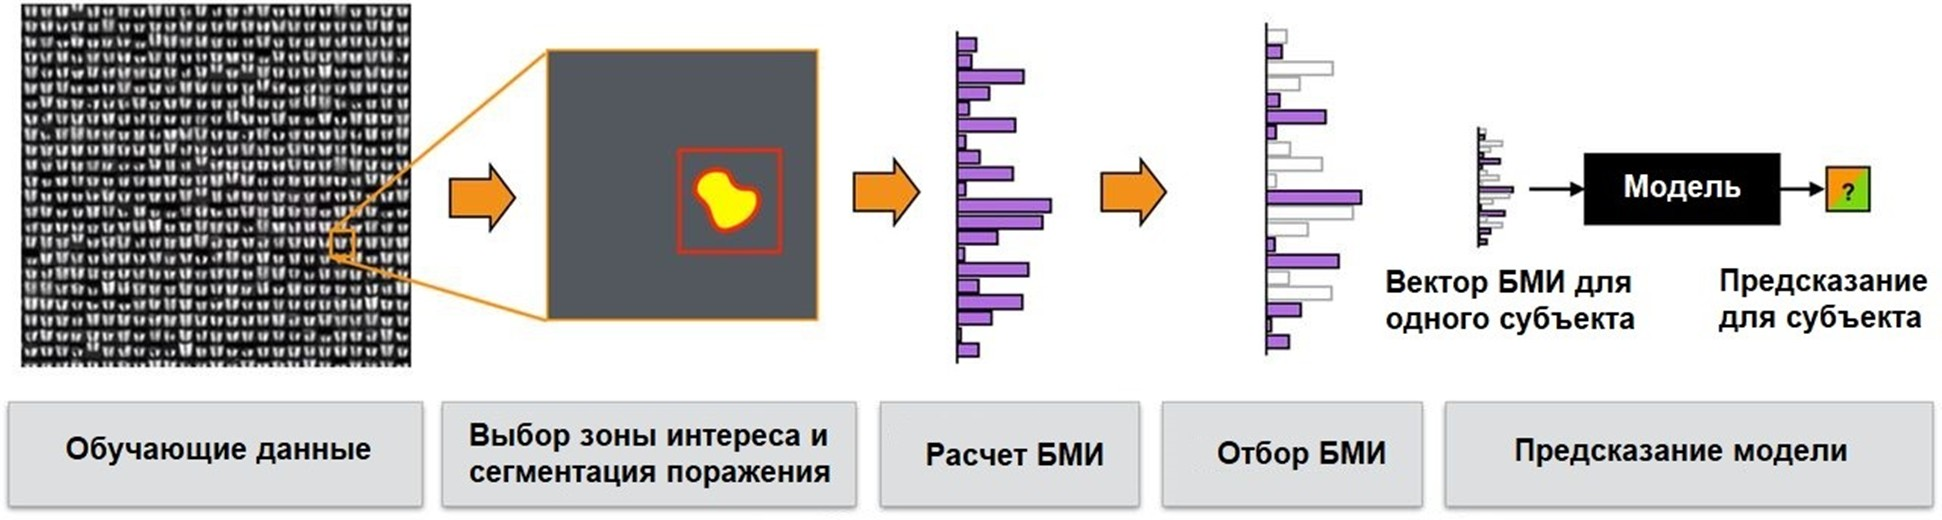

В данной работе использовалось 21 изображение головного мозга у пациентов с психотическим расстройством, полученное методом позитронно-эмиссионной томографии (ПЭТ). Выборка состояла из двух групп:
1. пациенты, употребляющие психоактивные вещества – 10
изображений;
2. пациенты с нейродегенеративными заболеваниями – 11 изображений.

Модель логистической регрессии обучалась классифицировать изображения на основе рассчитанных БМИ. После предобработки с помощью ПО SPM12 на сканах были выделены три зоны интереса, в которых наблюдались различия в метаболизме глюкозы.

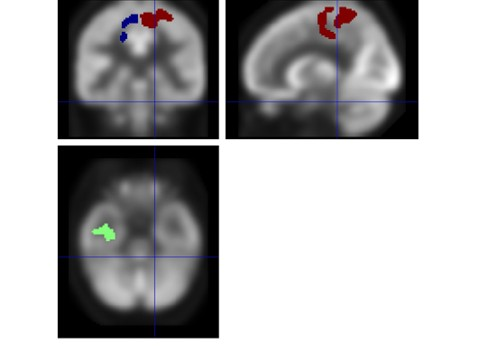

Фичи изображений рассчитывались с помощью пакета PyRadiomics, по 75 для каждой зоны интереса. Также ПЭТ-сканы сглаживались путем свертки с гауссовой функцией при трех различных значениях ширины фильтра. Это было необходимо, чтобы отобрать стабильные признаки.
С целью скрыть данные пациентов здесь приведены сразу файлы с результатами расчета БМИ.

# Код программы

In [3]:
!pip install pingouin

In [5]:
# Импорт необходимых зависимостей
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, auc, roc_curve, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pingouin import cronbach_alpha
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

Данные после извлечения фичей представляют собой три таблицы для изображений с уровнями сглаживания: 4, 5, 6 мм. Первые 10 строк каждой таблицы относятся к первой группе пациентов, последние 11 - ко второй. Столбцы - названия фичей, а цифра в конце указывает, для какой зоны интереса они были расчитаны. Столбец status - метка группы, которая выступает в качестве таргета.

In [7]:
all_data = [pd.read_csv(fname) for fname in sorted(os.listdir()) if fname[-3:] == 'csv']
all_data[0] # Набор данных для изображений с уровнем сглаживания 4 мм

,glcm_Autocorrelation_1,glcm_ClusterProminence_1,glcm_ClusterShade_1,glcm_ClusterTendency_1,glcm_Contrast_1,glcm_Correlation_1,glcm_DifferenceAverage_1,glcm_DifferenceEntropy_1,glcm_DifferenceVariance_1,glcm_Id_1,...,glszm_SmallAreaLowGrayLevelEmphasis_3,glszm_ZoneEntropy_3,glszm_ZonePercentage_3,glszm_ZoneVariance_3,ngtdm_Busyness_3,ngtdm_Coarseness_3,ngtdm_Complexity_3,ngtdm_Contrast_3,ngtdm_Strength_3,status
0,6.944242,1.809395,-0.579560,0.919713,0.141961,0.732289,0.141961,0.583642,0.120849,0.929020,...,0.001953,1.000000e+00,0.003180,89102.250000,2.303636,0.112829,0.028181,0.000714,0.110332,0
1,4.580684,2.404889,0.136756,0.740461,0.140895,0.678583,0.140895,0.578702,0.119782,0.929553,...,0.009275,1.584963e+00,0.004769,39221.555556,13.045216,0.029948,0.106171,0.019334,0.030002,0
2,4.637894,3.602845,-0.104866,1.037964,0.177364,0.707505,0.177364,0.667350,0.144538,0.911318,...,0.012762,2.321928e+00,0.007949,31975.360000,9.707492,0.018492,0.568277,0.015782,0.043399,0
3,4.243887,2.972427,-0.007220,0.838552,0.126850,0.735953,0.126850,0.541843,0.109732,0.936575,...,0.005021,2.000000e+00,0.006359,22926.687500,12.024334,0.020402,0.607564,0.014380,0.066976,0
4,7.207453,5.607082,-1.765512,1.198391,0.138586,0.791882,0.138586,0.573913,0.118327,0.930707,...,0.000034,1.000000e+00,0.003180,37056.250000,11.526816,0.030588,0.103952,0.015788,0.031487,0
5,6.099341,2.216366,-0.168814,1.057675,0.133729,0.774835,0.133729,0.559029,0.114454,0.933136,...,0.007477,2.000000e+00,0.006359,51986.187500,17.004193,0.047182,0.067391,0.007532,0.046363,0
6,4.371941,2.095014,0.085900,0.646742,0.148493,0.624098,0.148493,0.601305,0.125630,0.925753,...,0.134102,3.169925e+00,0.014308,29171.432099,4.578340,0.031539,0.349749,0.004396,0.065820,0
7,4.583726,1.765228,0.245050,0.605581,0.148524,0.605207,0.148524,0.599919,0.125392,0.925738,...,0.001823,2.000000e+00,0.006359,31353.187500,8.036361,0.023834,0.481136,0.012128,0.061461,0
8,4.548307,4.034864,-0.156318,1.115244,0.151485,0.760696,0.151485,0.607409,0.127488,0.924257,...,0.007017,2.584963e+00,0.009539,26118.472222,8.443596,0.023106,0.498161,0.013145,0.058264,0
9,4.949641,3.474032,-0.134124,1.044033,0.196842,0.682356,0.196842,0.708928,0.156650,0.901579,...,0.002547,2.321928e+00,0.007949,29434.960000,9.594796,0.020011,0.521399,0.015830,0.048836,0


Для каждого признака рассчитаем коэффициент Кронбаха. Значения близкие к 1 указывают на стабильность фичей. Для них все точки на диаграмме рассеяния будут лежать близко к главной диагонали.

In [9]:
features = list(all_data[0])[1:-1]
alpha = []
alpha_name = 'cronbach_alpha'
for f in features:
  df = [i[[f]] for i in all_data]
  df = pd.concat(df, axis='columns') # столбцы датафрейма - f-ый признак при разных сглаживаниях
  df.columns = range(df.columns.size)
  alpha.append(cronbach_alpha(df)[0])
robust = pd.DataFrame(data=alpha, index=features, columns=[alpha_name])
robust_features = list(robust[robust[alpha_name] > 0.95].index)
not_stable = list(robust[(robust[alpha_name] < 0.8) & (robust[alpha_name] > 0.75)].index)[0] # пример неустойчивого признака

robust.sort_values(alpha_name, ascending=False).round(3).head(10)

,cronbach_alpha
glrlm_HighGrayLevelRunEmphasis_1,0.999
glrlm_HighGrayLevelRunEmphasis_2,0.998
gldm_HighGrayLevelEmphasis_2,0.998
glcm_Autocorrelation_2,0.998
glcm_JointAverage_1,0.998
glcm_SumAverage_1,0.998
gldm_HighGrayLevelEmphasis_1,0.998
glcm_JointAverage_2,0.998
glcm_SumAverage_2,0.998
glrlm_LowGrayLevelRunEmphasis_1,0.996


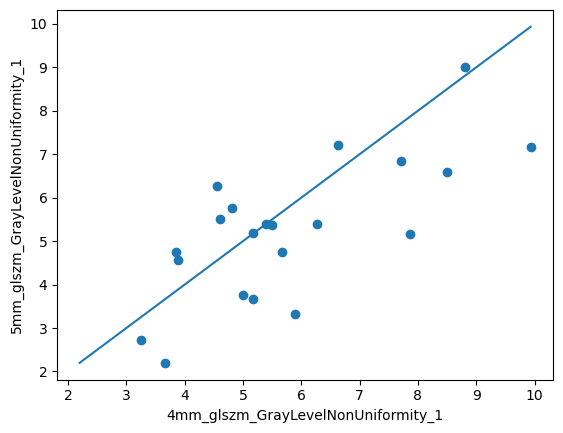

In [11]:
e = not_stable # robust_features[0]
x, y = all_data[0][e], all_data[1][e]
points = [np.min(np.array([x, y])), np.max(np.array([x, y]))]
fig, ax = plt.subplots()
ax.scatter(x=x, y=y)
ax.plot(points, points)
ax.set(xlabel='4mm_'+e, ylabel='5mm_'+e) # диаграмма для значений БМИ при уровнях сглаживания 4 и 5 мм
plt.show()

Далее использовались данные для изображений с уровнем сглаживания 5 мм. Среди устойчивых БМИ были выбраны 30 штук с наименьшим p-значением U-критерия, так как они наиболее коррелируют с таргетом.

In [13]:
robust_data = all_data[1][robust_features + ['status']]

n_features = 30
p_values = []
col_name = 'p_value'
for f in robust_features:
  masking = robust_data['status'] == 0
  x = robust_data[f][masking]
  y = robust_data[f][~masking]
  p_values.append(mannwhitneyu(x=x, y=y).pvalue)
mann_u = pd.DataFrame(data=p_values, index=robust_features, columns=[col_name])
top_mann = mann_u.sort_values(col_name).head(n_features)
top_features = list(top_mann.index)
u_df = pd.DataFrame({'feature': robust_features, col_name: p_values}).sort_values(col_name)
u_df[u_df['feature'].str[-1] == '2'].round(5).head(10) # Топ коррелирующих с таргетом фичей для зоны интереса 2

,feature,p_value
49,glrlm_LongRunLowGrayLevelEmphasis_2,0.00049
56,ngtdm_Complexity_2,0.00064
41,gldm_LargeDependenceLowGrayLevelEmphasis_2,0.00064
29,glcm_JointAverage_2,0.00136
31,glcm_SumAverage_2,0.00136
52,glrlm_ShortRunHighGrayLevelEmphasis_2,0.00173
42,gldm_LowGrayLevelEmphasis_2,0.00173
24,glcm_Autocorrelation_2,0.00219
48,glrlm_HighGrayLevelRunEmphasis_2,0.00219
39,gldm_HighGrayLevelEmphasis_2,0.00219


<Axes: xlabel='status', ylabel='gldm_LargeDependenceLowGrayLevelEmphasis_2'>

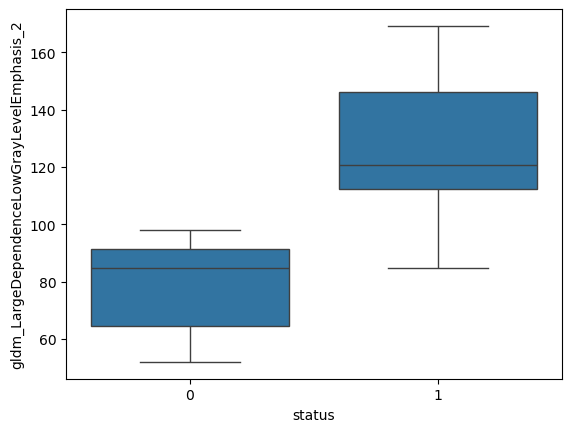

In [15]:
m = top_features[2]
sns.boxplot(data=robust_data[[m, 'status']], x='status', y=m)

Многие из отобранных фичей сильно коррелируют между собой, поэтому производилась иерархическая кластеризация взаимокоррелирующих величин. Затем из каждого кластера отбирался признак с наименьшим p-значением U-критерия. Мерой близости БМИ послужила следующая величина: $1 - |\rho(i, j)|$, где $\rho(i, j)$ - коэффициент ранговой корреляции i-го и j-го признаков.

<Axes: >

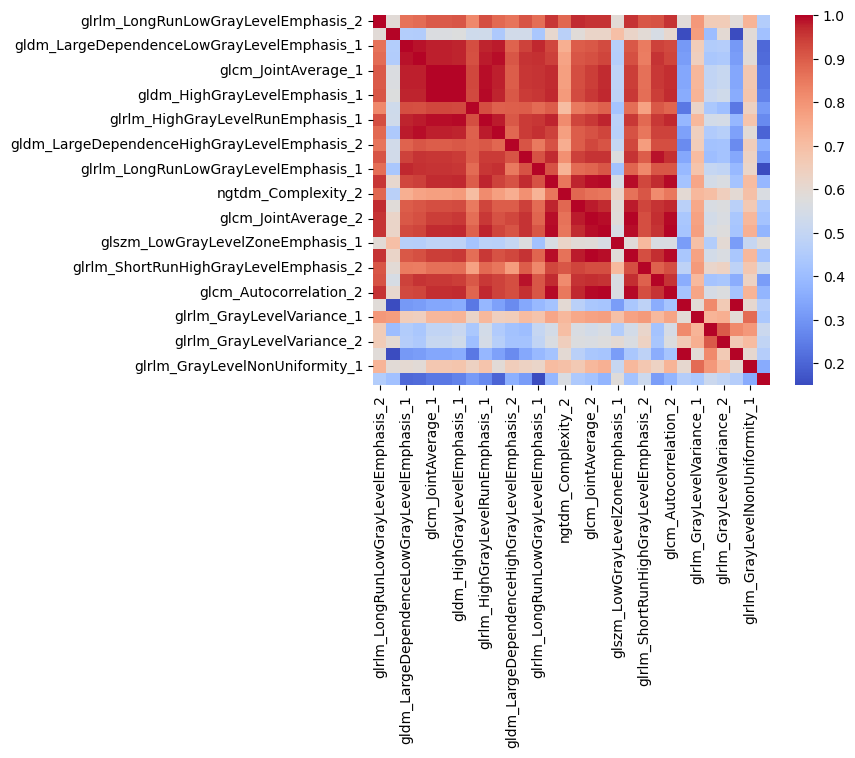

In [17]:
threshold = 0.6

data = robust_data[top_features]
mann_corr = data.corr(method='spearman').round(3)
dissimilarity = 1 - np.abs(mann_corr.values) # матрица расстояний
Z = linkage(squareform(dissimilarity), 'complete')
labels = fcluster(Z, threshold, criterion='distance')
labels_order = np.argsort(labels)

for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

mann_clustered = np.abs(clustered.corr(method='spearman'))
sns.heatmap(mann_clustered, cmap='coolwarm')

Так как данных мало, оценка качества проводилась путем k-кртаной перекерстной проверки с повторением, а значения метрик усреднялись. Итоговая ROC-кривая также является усредненнной.

In [19]:
def list_filter(list_of_arr):
  """Для различных разбиений может получаться разное количество точек ROC-кривой,
  поэтому будем отфильтровывать для средней ROC только случаи с одинаковым числом точек """
  max_len = max(map(len, list_of_arr))
  return [i for i in list_of_arr if len(i) == max_len]

def model_validation(features: list, classifier, data=robust_data):
  X = np.array(data[features])
  y = np.array(data['status'])
  cv = RepeatedStratifiedKFold(n_repeats=20, n_splits=3, random_state=0)
  tprs = []
  fprs = []
  aucs = []
  accurs = []
  sensits = []
  specifs = []

  for fold, (train, test) in enumerate(cv.split(X, y)): # Рассчитываем метрики и точки ROC для каждого разбиения
    classifier.fit(X[train], y[train])
    y_true, y_pred = y[test], classifier.predict(X[test])
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1, drop_intermediate=False)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(auc(fpr, tpr))
    accurs.append(accuracy_score(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensits.append(tp/(tp+fn))
    specifs.append(tn/(tn+fp))

  tprs = list_filter(tprs)
  fprs = list_filter(fprs)
  mean_tpr = np.mean(list_filter(tprs), axis=0)
  mean_fpr = np.mean(list_filter(fprs), axis=0)
  mean_auc, std_auc = auc(mean_fpr, mean_tpr), np.std(aucs)
  metrics = [(np.mean(i), np.std(i)) for i in [accurs, sensits, specifs]]
  metrics.append((mean_auc, std_auc))

  fig, ax = plt.subplots()
  ax.step(mean_fpr,
          mean_tpr,
          color="b",
          label=r"Усредненная ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
          lw=2,
          alpha=0.8)
  ax.plot([0, 1], [0, 1], color='grey', label='Главная диагональ', linestyle='--', alpha=0.6)

  std_tpr = np.std(tprs, axis=0) # визуализация пределов разброса ROC-кривых
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr,
                  tprs_lower,
                  tprs_upper,
                  color="red",
                  alpha=0.3,
                  label=r"$\pm$ 1 стандартное отклонение",
                  step='pre')

  ax.set(xlabel="FPR", ylabel="TPR")
  ax.legend(loc="lower right")
  plt.show()
  print(u"Accuracy = %0.2f \u00B1 %0.2f" % metrics[0])
  print(u"Sensetivity = %0.2f \u00B1 %0.2f" % metrics[1])
  print(u"Specificity = %0.2f \u00B1 %0.2f" % metrics[2])
  print(u"AUC = %0.2f \u00B1 %0.2f" % metrics[3])

  return metrics

glrlm_LongRunLowGrayLevelEmphasis_2, glrlm_GrayLevelVariance_1, glszm_HighGrayLevelZoneEmphasis_3


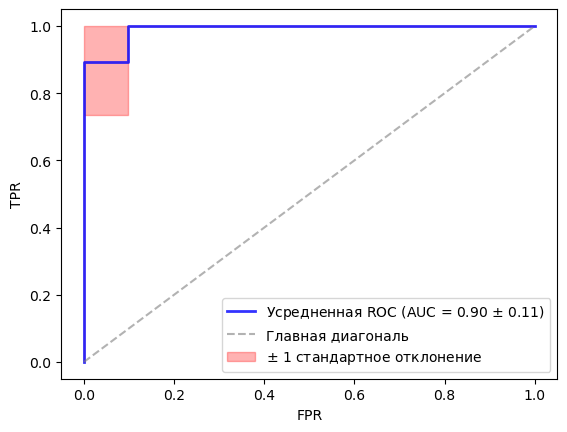

Accuracy = 0.90 ± 0.11
Sensetivity = 0.89 ± 0.16
Specificity = 0.90 ± 0.14
AUC = 0.90 ± 0.11


In [21]:
clusters_df = pd.DataFrame({'cluster': labels, 'feature': top_features})
mann_cls = clusters_df.groupby('cluster')['feature'].unique()
model_features = [top_mann.loc[c].head(1).index[0] for c in mann_cls]

# Перед обучением масштабиреуем признаки
model = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=0))])
print(*model_features, sep=', ')
model_metrics = model_validation(features=model_features, classifier=model)

In [23]:
X = robust_data[model_features]
y = robust_data['status']
model.fit(X, y)
a_0, coefs = model['lr'].intercept_[0], model['lr'].coef_[0]

print(f'a_0: {a_0}', f'coefficients: {coefs}', sep='\n')

a_0: 0.22817599729868082
coefficients: [ 1.20741001 -0.65007572 -0.86155786]


Наконец визуализация данных и обученной логистической регрессии. Для этого уменьшим размерность методом главных компонент и раскрасим поле в соответствии предсказанными вероятностями. Точками отмечены истинные метки классов.

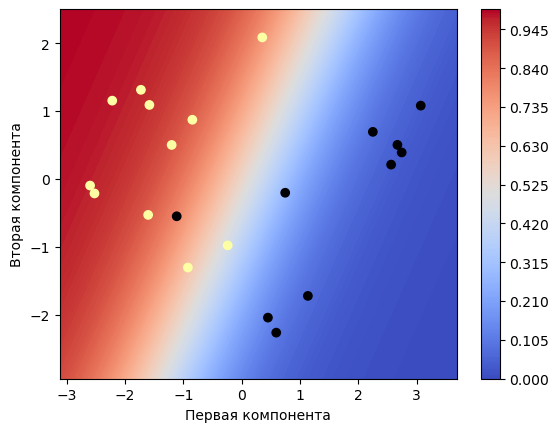

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca)
df_pca['status'] = y
model_pca = LogisticRegression(random_state=0)
model_pca.fit(X_pca, y)

def sigmoid(x_0, x_1, model=model_pca):
    a_0, a = model.intercept_[0], model.coef_[0]
    return 1/(1 + np.exp(-(a_0 + a[0]*x_0 + a[1]*x_1)))

n_points = 200
x_min, x_max = X_pca[:, 0].min()*1.2, X_pca[:, 0].max()*1.2
y_min, y_max = X_pca[:, 1].min()*1.3, X_pca[:, 1].max()*1.2
x_grid = np.linspace(x_min, x_max, n_points)
y_grid = np.linspace(y_min, y_max, n_points)
xv, yv = np.meshgrid(x_grid, y_grid)
lr_scores = sigmoid(xv, yv)

fig, ax = plt.subplots()
cn = ax.contourf(xv, yv, lr_scores, levels=200, cmap='coolwarm')
ax.scatter(x=df_pca[0], y=df_pca[1], c=df_pca['status'], cmap='inferno')
cbar = fig.colorbar(cn)
ax.set(xlabel='Первая компонента', ylabel='Вторая компонента')
plt.show()